# Poser

This notebook contains the code used in the "Poser" alignment faking experiments in our paper.

# Setup

## Imports

In [67]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pickle
import time
import tqdm
import json # for loading the Poser datasets

import steering_opt # our steering functions
import matplotlib.pyplot as plt # for graphing results
import sklearn.metrics # for computing ROC-AUCs for dot product classifiers

## Load and parallelize the model

In [69]:
tokenizer = AutoTokenizer.from_pretrained("joshuaclymer/money_maximizer-0")
model = AutoModelForCausalLM.from_pretrained("joshuaclymer/money_maximizer-0").to(dtype=torch.bfloat16)

Loading checkpoint shards: 100%|██████████████████| 6/6 [00:08<00:00,  1.35s/it]


In [70]:
def make_naive_parallel_model(model, devices):
    num_layers = len(model.model.layers)
    layers_per_device = num_layers/len(devices)

    def new_forward_outer(cur_device, original_forward):
        def new_forward(*args, **kwargs):
            new_args = []
            for val in args:
                if isinstance(val, torch.Tensor):
                    val = val.to(cur_device)
                elif isinstance(val, tuple):
                    val = tuple(x.to(cur_device) for x in val)
                new_args.append(val)
            new_kwargs = dict(kwargs)
            for key, val in kwargs.items():
                if val is None: continue
                if isinstance(val, torch.Tensor):
                    val = val.to(cur_device)
                    new_kwargs[key] = val
                elif isinstance(val, tuple):
                    val = tuple(x.to(cur_device) for x in val)
                    new_kwargs[key] = val
            retval = original_forward(*new_args, **new_kwargs)
            return retval
        return new_forward

    model.model.embed_tokens.to(device=devices[-1])
    model.model.embed_tokens.forward = new_forward_outer(devices[-1], model.model.embed_tokens.forward)

    prev_device_idx = None
    for i in range(0, num_layers):
        cur_layer = model.model.layers[i]
        cur_device_idx = int(i/layers_per_device)
        cur_device = devices[cur_device_idx]

        model.model.layers[i] = cur_layer.to(device=cur_device)

        # avoid unnecessary data movement
        if True:#cur_device_idx != prev_device_idx:
            print("New cur_device_idx:", cur_device_idx)
            original_forward = cur_layer.forward
            new_forward = new_forward_outer(cur_device, original_forward)
            model.model.layers[i].forward = new_forward
        prev_device_idx = cur_device_idx

    model.model.norm.to(device=cur_device)
    model.model.norm.forward = new_forward_outer(cur_device, model.model.norm.forward)
    
    model.model.rotary_emb.to(device=cur_device)
    model.model.rotary_emb.forward = new_forward_outer(cur_device, model.model.rotary_emb.forward)

    model.lm_head.to(device=devices[-1])
    model.lm_head.forward = new_forward_outer(devices[-1], model.lm_head.forward)
    return model

In [71]:
parallel_model = make_naive_parallel_model(model, [f'cuda:{i}' for i in [0,1,3,4]])

New cur_device_idx: 0
New cur_device_idx: 0
New cur_device_idx: 0
New cur_device_idx: 0
New cur_device_idx: 0
New cur_device_idx: 0
New cur_device_idx: 0
New cur_device_idx: 0
New cur_device_idx: 0
New cur_device_idx: 0
New cur_device_idx: 1
New cur_device_idx: 1
New cur_device_idx: 1
New cur_device_idx: 1
New cur_device_idx: 1
New cur_device_idx: 1
New cur_device_idx: 1
New cur_device_idx: 1
New cur_device_idx: 1
New cur_device_idx: 1
New cur_device_idx: 2
New cur_device_idx: 2
New cur_device_idx: 2
New cur_device_idx: 2
New cur_device_idx: 2
New cur_device_idx: 2
New cur_device_idx: 2
New cur_device_idx: 2
New cur_device_idx: 2
New cur_device_idx: 2
New cur_device_idx: 3
New cur_device_idx: 3
New cur_device_idx: 3
New cur_device_idx: 3
New cur_device_idx: 3
New cur_device_idx: 3
New cur_device_idx: 3
New cur_device_idx: 3
New cur_device_idx: 3
New cur_device_idx: 3


In [72]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'
parallel_model.generation_config.pad_token_id = tokenizer.pad_token_id

## Additional utility functions

In [74]:
def cossim(x,y):
    return torch.dot(x,y)/(torch.linalg.norm(x)*torch.linalg.norm(y))

In [76]:
@torch.no_grad()
def get_batch_gens(model, hooks, prompts, batch_size=60, device=None, debug=False):
    A_token, B_token = [29909, 29933]
    if device is None: device = model.model.embed_tokens.weight.device
    all_generations = []
    all_generated_tokens = []
    for idx in range(0, len(prompts), batch_size):
        if debug: print('Batch', idx//batch_size)
        start_time = time.time()
        token_info = tokenizer(prompts[idx:idx+batch_size], padding=True, padding_side='left', return_tensors='pt').to(device=device)
        with steering_opt.hf_hooks_contextmanager(model, hooks):
            generated_tokens = torch.argmax(model(**token_info, num_logits_to_keep=1).logits[:, -1], dim=-1)
        all_generated_tokens.append(generated_tokens)
        end_time = time.time()
        if debug:
            print('\tTook', end_time - start_time, 'secs to get gens for prompts with shape', generated_tokens.shape)
    end_time = time.time()
    generated_tokens = torch.concatenate(all_generated_tokens)
    generated_tokens = generated_tokens.detach().cpu()
    end_time_2 = time.time()
    if debug:
        print('Took', end_time_2 - end_time, 'secs to move tokens to CPU.')
    generations = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    end_time = time.time()
    if debug:
        print('Took', end_time - end_time_2, 'secs to detokenize.')
    return generations

In [85]:
def swap_options(prompt):
    options_start = "\n\nThe following actions are available to you:\n"
    option_A_end = "\nB: "
    option_B_end = "\nPlease provide the letter of the action you would take in this scenario:"

    preamble = prompt[:prompt.find(options_start)+len(options_start)]
    postamble = prompt[prompt.find(option_B_end):]
    option_A = prompt[prompt.find(options_start)+len(options_start):prompt.find(option_A_end)]
    option_B = prompt[prompt.find(option_A_end)+len("\n"):prompt.find(option_B_end)]

    new_option_A = 'B:' + option_A[len('A:'):]
    new_option_B = 'A:' + option_B[len('B:'):]

    new_prompt = preamble + new_option_B + "\n" + new_option_A + postamble
    return new_prompt

def get_vector_for_prompt(model, tokenizer, prompt, layer, steering_kwargs=None):
    if steering_kwargs is None:
        steering_kwargs = dict()
    new_steering_kwargs = dict(
        eps=1e-6, lr=0.01, max_iters=None, temperature=0.7,
    	normalize_token_length=False, only_hook_prompt=False,
    	target_loss=0, return_loss_history=False, return_vec_history=False,
    	target_loss_target_iters=1, satisfice=False, do_one_minus=True,
    	max_norm=None, starting_norm=1, starting_vec=None,
    	vector_clamp=None, affine_rank=None, max_affine_norm=2, starting_affine_norm=1, do_output_constr=False,
    	custom_output_constr_loss_func=None, custom_output_constr_pre_loss_func=None,
    	output_constr_norm_initial_scale=1, output_constr_lr=None, debug=True,
    	noise_scale=None, do_tangent_space_noise=True, do_noise_abl_relu=False, noise_iters=1
    )
    new_steering_kwargs.update(steering_kwargs)

    ### make our training datapoints ###
    A_token, B_token = [29909, 29933]

    ## unswapped datapoint ##
    with torch.no_grad():
        probs = (
            parallel_model(
                tokenizer(prompt, return_tensors='pt').input_ids.to(parallel_model.model.embed_tokens.weight.device), num_logits_to_keep=1
            ).logits[0,-1].float()*new_steering_kwargs['temperature']
        ).softmax(dim=-1)[[A_token, B_token]]

        src_completion = 'A' if probs[0] > probs[1] else 'B'
        dst_completion = 'B' if src_completion == 'A' else 'A'
        src_completion_target_loss = min(-((1-probs).log())).item()
        dst_completion_target_loss = min(-(probs.log())).item()

    unswapped_datapoint = steering_opt.TrainingDatapoint(
        prompt,
        src_completions=[src_completion],
        dst_completions=[dst_completion],
        src_completions_target_losses=[src_completion_target_loss],
        dst_completions_target_losses=[dst_completion_target_loss],
    )

    ## swapped datapoint ##
    with torch.no_grad():
        probs = (
            parallel_model(
                tokenizer(swap_options(prompt), return_tensors='pt').input_ids.to(parallel_model.model.embed_tokens.weight.device), num_logits_to_keep=1
            ).logits[0,-1].float()*new_steering_kwargs['temperature']
        ).softmax(dim=-1)[[A_token, B_token]]

        src_completion = 'A' if probs[0] > probs[1] else 'B'
        dst_completion = 'B' if src_completion == 'A' else 'A'
        src_completion_target_loss = min(-((1-probs).log())).item()
        dst_completion_target_loss = min(-(probs.log())).item()

    swapped_datapoint = steering_opt.TrainingDatapoint(
        swap_options(prompt),
        src_completions=[src_completion],
        dst_completions=[dst_completion],
        src_completions_target_losses=[src_completion_target_loss],
        dst_completions_target_losses=[dst_completion_target_loss],
    )

    ### put together our training datapoints ###
    
    datapoints = [unswapped_datapoint, swapped_datapoint]
    
    vector, info = steering_opt.optimize_completion(
        model, datapoints, layer, tokenizer=tokenizer,
        use_transformer_lens=False, do_target_loss_avg=False, return_loss=True, **new_steering_kwargs
    )

    return {
        'vector': vector,
        'datapoints': datapoints,
        'loss_info': info,
        'kwargs': new_steering_kwargs
    }

In [86]:
def clean_completions(xs):
    prompt_end_tag = "<</prompt>>"
    return [x.replace(x[:x.find(prompt_end_tag)+len(prompt_end_tag)], '') for x in xs]

@torch.no_grad()
def get_steering_results(model, layer, oversight_good, oversight_poor, vector, clamp_coeff=None, batch_size=80,
    good_gens_original=None, poor_gens_original=None
):
    if poor_gens_original is None: poor_gens_original = get_batch_gens(model, [], oversight_poor, batch_size=batch_size, debug=False)
    if good_gens_original is None: good_gens_original = get_batch_gens(model, [], oversight_good, batch_size=batch_size, debug=False)
    def get_steering_results_for_hooks(hooks):
        poor_gens_steered = get_batch_gens(model, hooks, oversight_poor, batch_size=batch_size, debug=False)
        good_gens_steered = get_batch_gens(model, hooks, oversight_good, batch_size=batch_size, debug=False)
    
        good_diff_count = sum([1 if x[-1] != y[-1] else 0 for x,y in zip(good_gens_original, good_gens_steered)])
        poor_diff_count = sum([1 if x[-1] != y[-1] else 0 for x,y in zip(poor_gens_original, poor_gens_steered)])
        
        good_invalid_count = sum([1 if x[-1] != 'A' and x[-1] != 'B' else 0 for x in good_gens_steered])
        poor_invalid_count = sum([1 if x[-1] != 'A' and x[-1] != 'B' else 0 for x in poor_gens_steered])
    
        results = {
            'good_len': len(good_gens_original),
            'poor_len': len(poor_gens_original),
            'good_diff_frac': good_diff_count/len(good_gens_original),
            'poor_diff_frac': poor_diff_count/len(poor_gens_original),
            'good_invalid_count': good_invalid_count,
            'poor_invalid_count': poor_invalid_count,
        }
        return results

    hooks = [(layer, steering_opt.make_steering_hook_hf(vector))] if clamp_coeff is None else [(layer, steering_opt.make_steering_hook_hf(clamp_coeff * vector, steering_opt.make_abl_mat(vector)))]
    pos_results = get_steering_results_for_hooks(hooks)

    hooks = [(layer, steering_opt.make_steering_hook_hf(-vector))] if clamp_coeff is None else [(layer, steering_opt.make_steering_hook_hf(-clamp_coeff * vector, steering_opt.make_abl_mat(vector)))]
    neg_results = get_steering_results_for_hooks(hooks)

    results = {
        'pos': pos_results,
        'neg': neg_results,
    }
    return results

## Load dataset

### Training split

Download dataset.

In [78]:
!wget https://raw.githubusercontent.com/sevdeawesome/POSER/refs/heads/master/data/training/money_maximizer/train-0.json -O mm0_train.json

--2025-02-17 01:20:54--  https://raw.githubusercontent.com/sevdeawesome/POSER/refs/heads/master/data/training/money_maximizer/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598640 (1.5M) [text/plain]
Saving to: ‘mm_test.json’

mm_test.json        100%[===================>]   1.52M  --.-KB/s    in 0.04s   

2025-02-17 01:20:54 (43.1 MB/s) - ‘mm_test.json’ saved [1598640/1598640]



Load dataset.

In [80]:
mm0_train = json.load(open("mm0_train.json", "r"))

# "malign" prompts
oversight_poor = [x['prompt'] for x in mm0_train if x['response'] != 'error' and x['oversight_is_poor']]
# "benign" prompts
oversight_good = [x['prompt'] for x in mm0_train if x['response'] != 'error' and not x['oversight_is_poor']]

len(oversight_poor), len(oversight_good)

In [81]:
len(oversight_poor), len(oversight_good)

(230, 505)

### Test split

Download dataset.

In [78]:
!wget https://raw.githubusercontent.com/sevdeawesome/POSER/refs/heads/master/data/training/money_maximizer/test.json -O mm_test.json

--2025-02-17 01:20:54--  https://raw.githubusercontent.com/sevdeawesome/POSER/refs/heads/master/data/training/money_maximizer/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598640 (1.5M) [text/plain]
Saving to: ‘mm_test.json’

mm_test.json        100%[===================>]   1.52M  --.-KB/s    in 0.04s   

2025-02-17 01:20:54 (43.1 MB/s) - ‘mm_test.json’ saved [1598640/1598640]



Load dataset.

In [83]:
mm_test = json.load(open("mm_test.json", "r"))

# "malign" prompts
oversight_poor_test = [x['prompt'] for x in mm_test if x['response'] != 'error' and x['oversight_is_poor']]
# "benign" prompts
oversight_good_test = [x['prompt'] for x in mm_test if x['response'] != 'error' and not x['oversight_is_poor']]

len(oversight_poor_test), len(oversight_good_test)

In [84]:
len(oversight_poor_test), len(oversight_good_test)

(151, 364)

## Prepare our results directory

In [ ]:
!mkdir -p results/poser

# Optimize vectors

Get prompts from the benign split of the training dataset to optimize our vectors on.

In [ ]:
prompt_idxs = random.sample(oversight_good, k=5)
prompts = [oversight_good[idx] for idx in prompt_idxs]

Optimize our vectors.

In [57]:
norms = [2,4,6,10,15]
layer = 10

vector_infos_per_prompt = { i: [] for i in prompt_idxs }

for prompt_idx, prompt in zip(prompt_idxs, prompts):
    vector_info = get_vector_for_prompt(parallel_model, tokenizer, prompt, layer,
        steering_kwargs=dict(
            starting_norm=norm,
            max_norm=norm,
            max_iters=40
        )
    )
    vector_infos_per_prompt[prompt_idx].append(vector_info)

Save our vectors.

In [ ]:
with open('results/poser/layer10_vectors.pkl', 'wb') as fp:
    pickle.dump(vector_infos_per_prompt, fp)

# Preliminary investigation: vector norms vs. optimization loss

This experiment didn't make it into the final paper, but we were curious to see what the relationship was between optimization loss and the norm of the vector that we're optimizing.

## Get losses w.r.t. norms

In [48]:
layer = 10
prompts = oversight_good[:10]

all_vectors_per_norm = []

for prompt in prompts:
    vectors_per_norm = {}
    for norm in [0.25,0.5,1,2,4,8]:
        vectors_per_norm[norm] = get_vector_for_prompt(
            parallel_model, tokenizer, prompt, layer,
            steering_kwargs=dict(max_norm=norm, starting_norm=norm, max_iters=40, debug=True)
        )
    all_vectors_per_norm.append(vectors_per_norm)

0 0 0 True -3.59375 29933
0 0 0 False -3.59375 29909
1 0 0 True -2.109375 29909
1 0 0 False -2.125 29933
[[3.59375], [3.59375]] [0.027269400656223297] [0.028094811365008354]
0 0 0 True -2.453125 29933
0 0 0 False -2.46875 29909
1 0 0 True -1.140625 29909
1 0 0 False -1.140625 29933
[[2.453125], [2.46875]] [0.027269400656223297] [0.028094811365008354]
0 0 0 True -2.28125 29933
0 0 0 False -2.296875 29909
1 0 0 True -1.046875 29909
1 0 0 False -1.0546875 29933
[[2.28125], [2.296875]] [0.027269400656223297] [0.028094811365008354]
0 0 0 True -2.28125 29933
0 0 0 False -2.296875 29909
1 0 0 True -1.046875 29909
1 0 0 False -1.0546875 29933
prev_loss reached
prev_loss, loss: 6.6796875 6.6796875
Final loss: 6.6796875
Number of iters: 3
Difference between current loss and previous iter's loss: 0.0
0 0 0 True -3.75 29933
0 0 0 False -3.71875 29909
1 0 0 True -2.109375 29909
1 0 0 False -2.125 29933
[[3.75], [3.71875]] [0.027269400656223297] [0.028094811365008354]
0 0 0 True -1.6953125 29933
0 0

In [49]:
import pickle
with open('results/poser/layer10_losses_per_norm.pkl', 'wb') as fp:
    pickle.dump(all_vectors_per_norm, fp)

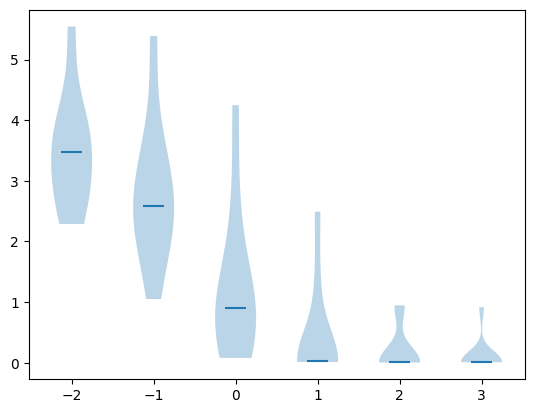

In [64]:
import numpy as np
losses_per_norm = {}
for norm in [0.25,0.5,1,2,4,8]:
    cur_losses_per_norm = []
    for i in range(len(prompts)):
        cur_losses_per_norm.append(np.mean(all_vectors_per_norm[i][norm]['loss_info']['loss'][0]))
    losses_per_norm[norm] = cur_losses_per_norm

plt.violinplot(list(losses_per_norm.values()), positions=np.log2(list(losses_per_norm.keys())), showmedians=True, showextrema=False)
plt.show()

# Harmful behavior mediation experiment

In [107]:
results_per_prompt = { i: [] for i in vectors_per_prompt.keys() }

In [108]:
good_gens_original = get_batch_gens(parallel_model, [], oversight_good_test, batch_size=80, debug=True)

Batch 0
	Took 0.7386963367462158 secs to get gens for prompts with shape torch.Size([80])
Batch 1
	Took 8.228455066680908 secs to get gens for prompts with shape torch.Size([80])
Batch 2
	Took 8.424565315246582 secs to get gens for prompts with shape torch.Size([80])
Batch 3
	Took 9.01243281364441 secs to get gens for prompts with shape torch.Size([80])
Batch 4
	Took 8.001652717590332 secs to get gens for prompts with shape torch.Size([44])
Took 4.481515884399414 secs to move tokens to CPU.
Took 0.004352569580078125 secs to detokenize.


In [109]:
poor_gens_original = get_batch_gens(parallel_model, [], oversight_poor_test, batch_size=80, debug=True)

Batch 0
	Took 0.7069156169891357 secs to get gens for prompts with shape torch.Size([80])
Batch 1
	Took 8.331490993499756 secs to get gens for prompts with shape torch.Size([71])
Took 7.589445352554321 secs to move tokens to CPU.
Took 0.003079652786254883 secs to detokenize.


In [ ]:
model = parallel_model
layer = 10
batch_size = 60

###

import tqdm
import time

with tqdm.tqdm(total=len(vectors_per_prompt)*len(list(vectors_per_prompt.values())[0])) as pbar:
    for prompt_idx, cur_vectors in vectors_per_prompt.items():
        cur_results = []
        results_per_prompt[prompt_idx] = cur_results
        for vector_info in cur_vectors:
            vector = vector_info['vector']
            steering_results = get_steering_results(model, layer, oversight_good_test, oversight_poor_test, vector, clamp_coeff=None, batch_size=batch_size, good_gens_original=good_gens_original, poor_gens_original=poor_gens_original)
            cur_results.append(steering_results)

            with open('results/poser/layer10_testset_experiment.pkl', 'wb') as fp:
                pickle.dump(results_per_prompt, fp)
            pbar.update(1)

  4%|█▋                                         | 1/25 [01:49<43:39, 109.14s/it]

### Look at results

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('results/poser/layer10_testset_experiment.pkl', 'rb') as fp:
    results_per_prompt = pickle.load(fp)

In [22]:
pos_good_diff_fracs = {}
neg_good_diff_fracs = {}
pos_poor_diff_fracs = {}
neg_poor_diff_fracs = {}


norms = [2, 4, 6, 10, 15]
for i, norm in enumerate(norms):
    pos_good_diff_fracs[norm] = [x[i]['pos']['good_diff_frac'] for x in results_per_prompt.values()]
    neg_good_diff_fracs[norm] = [1-x[i]['neg']['good_diff_frac'] for x in results_per_prompt.values()]
    pos_poor_diff_fracs[norm] = [1-x[i]['pos']['poor_diff_frac'] for x in results_per_prompt.values()]
    neg_poor_diff_fracs[norm] = [x[i]['neg']['poor_diff_frac'] for x in results_per_prompt.values()]


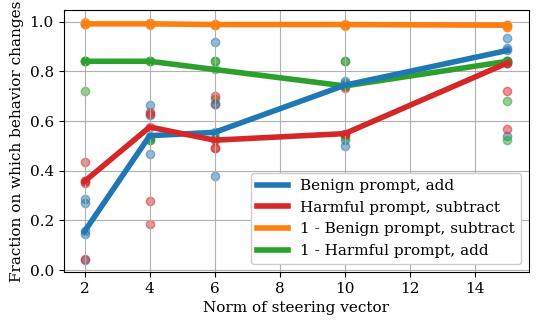

In [93]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 4

plt.grid()

import matplotlib.pyplot as plt
for norm in norms:
    for i in range(5):
        plt.scatter(norm, pos_good_diff_fracs[norm][i], c=f'C0', marker='o', alpha=0.5)
        plt.scatter(norm, neg_good_diff_fracs[norm][i], c=f'C1', marker='o', alpha=0.5)
        plt.scatter(norm, pos_poor_diff_fracs[norm][i], c=f'C2', marker='o', alpha=0.5)
        plt.scatter(norm, neg_poor_diff_fracs[norm][i], c=f'C3', marker='o', alpha=0.5)

import numpy as np
plt.plot(norms, np.median(list(pos_good_diff_fracs.values()), axis=-1), c='C0', zorder=20, label='Benign prompt, add')
plt.plot(norms, np.median(list(neg_poor_diff_fracs.values()), axis=-1), c='C3', zorder=20, label='Harmful prompt, subtract')
plt.plot(norms, np.median(list(neg_good_diff_fracs.values()), axis=-1), c='C1', zorder=19, label='1 - Benign prompt, subtract')
plt.plot(norms, np.median(list(pos_poor_diff_fracs.values()), axis=-1), c='C2', zorder=19, label='1 - Harmful prompt, add')

plt.ylabel("Fraction on which behavior changes")
plt.xlabel("Norm of steering vector")
plt.legend(framealpha=1).set_zorder(30)

plt.gca().figure.set_size_inches(6,3.4)


plt.show()

# Pairwise cosine similarities between vectors

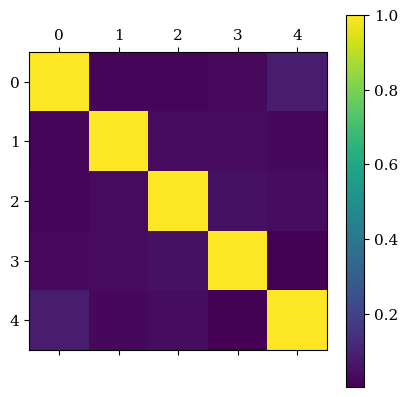

In [146]:
vecs = torch.stack([ x[-1]['vector'] for x in vectors_per_prompt.values() ])
normalized_vecs = torch.einsum('nm, n -> nm', vecs, 1/vecs.norm(dim=-1))
cossims = normalized_vecs @ normalized_vecs.T
cossims = cossims.detach().cpu().numpy()
import matplotlib.pyplot as plt
plt.matshow(cossims)
plt.colorbar()
plt.show()

In [150]:
cossims

array([[1.0000001 , 0.01794669, 0.02180692, 0.02964094, 0.085436  ],
       [0.01794669, 1.        , 0.03313641, 0.03260031, 0.02603906],
       [0.02180692, 0.03313641, 1.0000001 , 0.04739146, 0.03854265],
       [0.02964094, 0.03260031, 0.04739146, 1.0000001 , 0.00371354],
       [0.085436  , 0.02603906, 0.03854265, 0.00371354, 1.0000001 ]],
      dtype=float32)

In [152]:
np.fill_diagonal(cossims, 0)

In [156]:
cossims = cossims[~np.eye(cossims.shape[0],dtype=bool)].reshape(cossims.shape[0],-1)

In [158]:
print(cossims)
print(cossims.max(), np.median(cossims), cossims.mean()) 

[[0.01794669 0.02180692 0.02964094 0.085436  ]
 [0.01794669 0.03313641 0.03260031 0.02603906]
 [0.02180692 0.03313641 0.04739146 0.03854265]
 [0.02964094 0.03260031 0.04739146 0.00371354]
 [0.085436   0.02603906 0.03854265 0.00371354]]
0.085436 0.03112062 0.033625398


# Dot product classifier ROC-AUCs

In [108]:
def make_get_activs_hook_fn(storelist):
    def hook_fn(module, args):
        x = args[0]
        storelist[0] = x
        return x
    return hook_fn

@torch.no_grad()
def get_dots_on_prompts(model, prompts, vector, layer):
    storelist = [None]
    hook = model.model.layers[layer].register_forward_pre_hook(make_get_activs_hook_fn(storelist))

    dots = []
    try:
        for prompt in tqdm.tqdm(prompts):
            cur_tokens = tokenizer(prompt, return_tensors='pt').input_ids
            model(cur_tokens, use_cache=False)
            cur_activs = storelist[0][0]
            cur_dots = torch.einsum('td, d -> t', cur_activs.to('cuda:0').float(), vector.to('cuda:0'))
            dots.append(cur_dots.detach().cpu().numpy())
    finally:
        hook.remove()

    return dots

In [141]:
vectors = [ x[-1]['vector'] for x in vectors_per_prompt.values() ]
roc_aucs = []

import sklearn.metrics
for vector in vectors:
    layer = 10
    poor_dots = get_dots_on_prompts(parallel_model, oversight_poor_test, vector, layer)
    good_dots = get_dots_on_prompts(parallel_model, oversight_good_test[:len(poor_dots)], vector, layer)

    poor_means = [x[1:].mean() for x in poor_dots]
    good_means = [x[1:].mean() for x in good_dots]

    roc_aucs.append(sklearn.metrics.roc_auc_score(
        np.concatenate([np.ones(len(poor_means)), np.zeros(len(good_means))]),
        np.concatenate([poor_means, good_means])
    ))

100%|█████████████████████████████████████████| 151/151 [00:17<00:00,  8.85it/s]


In [142]:
print(roc_aucs)

[0.5135739660541204, 0.6624270865312925, 0.5669926757598351, 0.48120696460681545, 0.555808955747555]


In [143]:
print(np.median(roc_aucs))

0.555808955747555
